In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,ParameterGrid
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.metrics import accuracy_score,f1_score
%matplotlib inline

In [2]:
train_df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau = pd.read_csv('bureau.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv')
installments_payments =  pd.read_csv('installments_payments.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
train_df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [5]:
def missing_value_table(df):
    #total missing value
    mis_val = df.isnull().sum()

    #percentage of missing value
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    #make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent],axis=1)

    #rename the columns 
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0 : 'missing values',1 : '% of total values'}
    )
    #sort the table by percentage of missing decsending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of total values',ascending=False).round(1)

    #print summary information
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'
          'There are ' + str(mis_val_table_ren_columns.shape[0]) + 
          ' columns that have missing values'
    )

    #return the dataframe with missing information
    return mis_val_table_ren_columns


In [6]:
missing_value_table(train_df)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values


,missing values,% of total values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [7]:
train_df.select_dtypes('object').apply(pd.Series.nunique,axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
le = LabelEncoder()
le_count = 0

for col in train_df:
    if train_df[col].dtype == 'object':
        if len(list(train_df[col].unique())) <= 2:

            le.fit(train_df[col])
            train_df[col] = le.transform(train_df[col])
            test_df[col] = le.transform(test_df[col])

            le_count += 1

print('%d columns were label encoded' %le_count)

3 columns were label encoded


In [9]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

print('Training Feature shape: ', train_df.shape)
print('Test Feature shape: ', test_df.shape)

Training Feature shape:  (307511, 243)
Test Feature shape:  (48744, 239)


In [10]:
train_labels = train_df['TARGET']

train_df, test_df = train_df.align(test_df, join='inner',axis=1)

train_df['TARGET'] = train_labels

print('Training Feature Shape: ', train_df.shape)
print('Test Feature Shape: ', test_df.shape)

Training Feature Shape:  (307511, 240)
Test Feature Shape:  (48744, 239)


In [11]:
(train_df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [12]:
train_df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

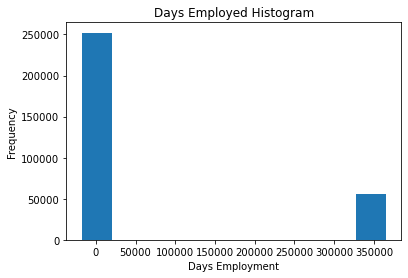

In [13]:
train_df['DAYS_EMPLOYED'].plot.hist(title='Days Employed Histogram')
plt.xlabel('Days Employment')

Text(0.5, 0, 'Days Employment')

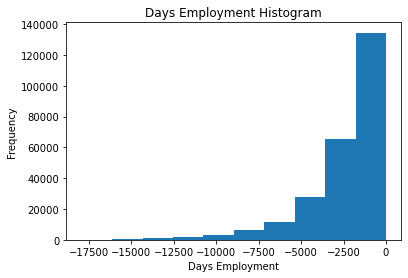

In [14]:
#create an anomalous flag column
train_df['DAYS_EMPLOYED_ANOM'] = train_df['DAYS_EMPLOYED'] == 365243

#Replace the anomalous values with nan
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

train_df['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [15]:
test_df['DAYS_EMPLOYED_ANOM'] = test_df['DAYS_EMPLOYED'] == 365243
test_df['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (test_df['DAYS_EMPLOYED_ANOM'].sum(),len(test_df)))  

There are 9274 anomalies in the test data out of 48744 entries


In [16]:
#Find correlations with the target and sort
correlations = train_df.corr()['TARGET'].sort_values()

#Display correlations
print('Most Positive Correlations:\n',correlations.tail(15))
print('\nMost Negative Correlaitons:\n',correlations.head(15))


Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [17]:
#Find the correlation of the positive days since birth and target

train_df['DAYS_BIRTH'] = abs(train_df['DAYS_BIRTH'])
train_df['DAYS_BIRTH'].corr(train_df['TARGET'])


-0.07823930830982712

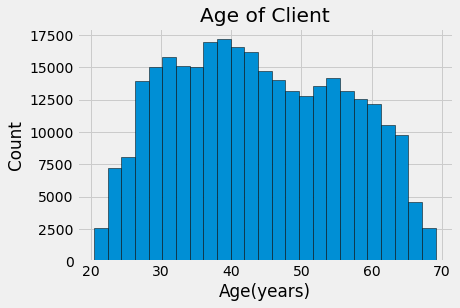

In [24]:
#set the style of plots
plt.style.use('fivethirtyeight')

#plot the distribution of ages in years 
plt.hist(train_df['DAYS_BIRTH']/365, edgecolor='k', bins=25)
plt.title('Age of Client'); plt.xlabel('Age(years)'); plt.ylabel('Count'); 


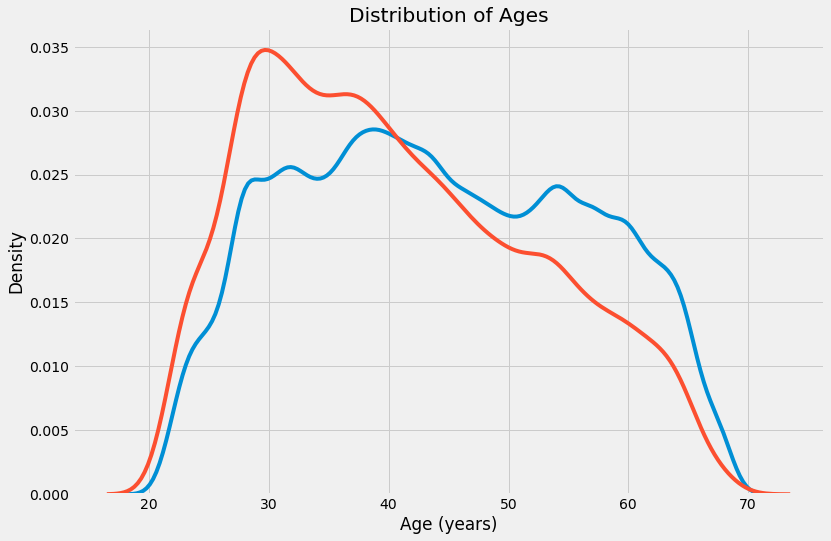

In [28]:
plt.figure(figsize=(12,8))

#KDE plot of loans that were repaid on time 
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'DAYS_BIRTH'] /365,label='target = 0')

#KDE plot of loans that were not repaid on time
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'DAYS_BIRTH']/365,label='target = 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


In [30]:
#Age information into a separate dataframe
age_data = train_df[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

#Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

<ipython-input-30-97f457c8dfb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365
<ipython-input-30-97f457c8dfb7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [31]:
#Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to repay by age group')

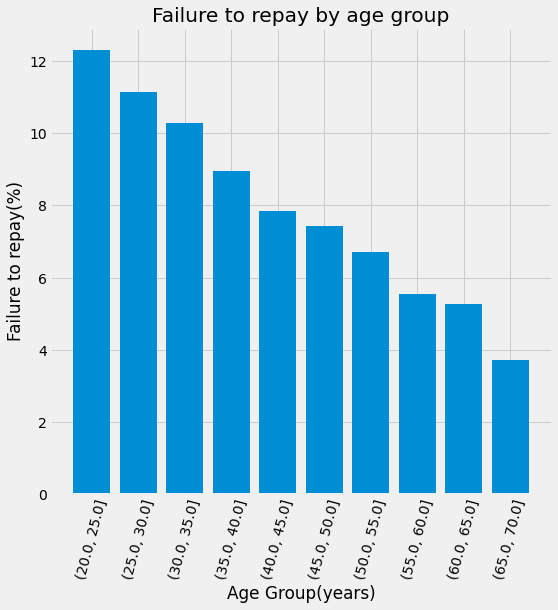

In [32]:
plt.figure(figsize=(8,8))
#graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str),100*age_groups['TARGET'])

#plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group(years)')
plt.ylabel('Failure to repay(%)')
plt.title('Failure to repay by age group')

In [33]:
#Extract the EXT_SOURCE variables and show correlations
ext_data = train_df[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


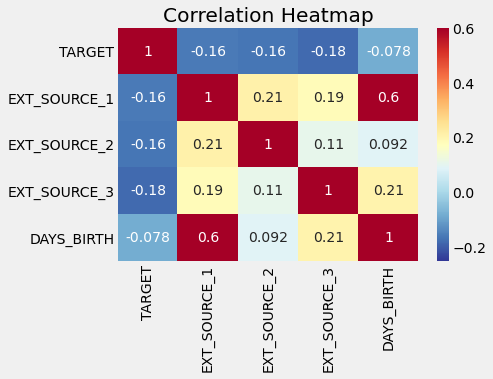

In [35]:
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


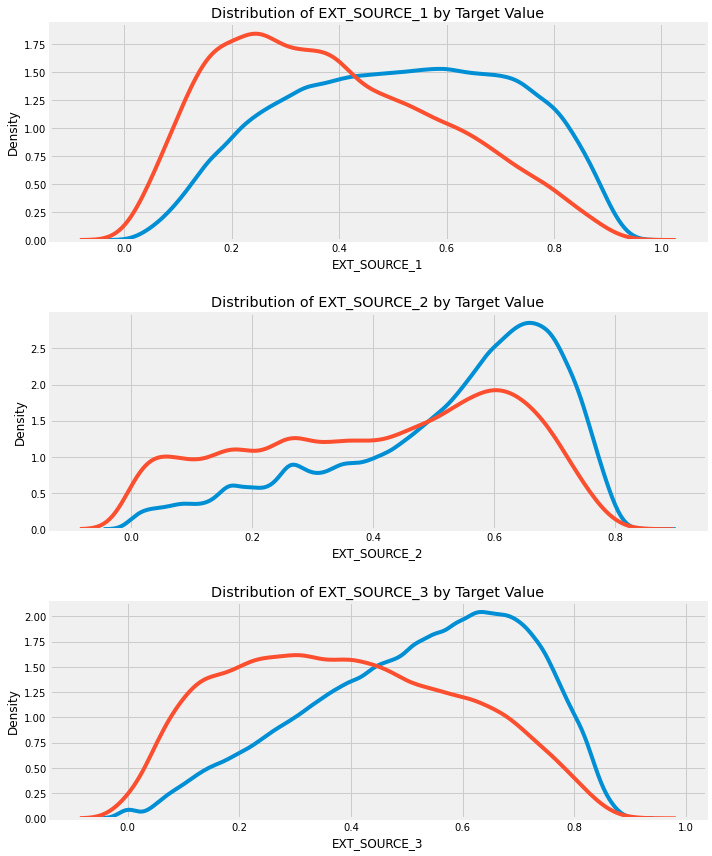

In [41]:
plt.figure(figsize=(10,12))

#iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    #create a new subplot for each sources
    plt.subplot(3,1,i+1)
    #plot repaid loans
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, source], label = 'target=0')
    #plot loans that were not repaid
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, source], label='target = 1')

    #label the plots
    plt.title('Distribution of %s by Target Value'%source)
    plt.xlabel('%s'%source)
    plt.ylabel('Density')


plt.tight_layout(h_pad = 2.5)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  

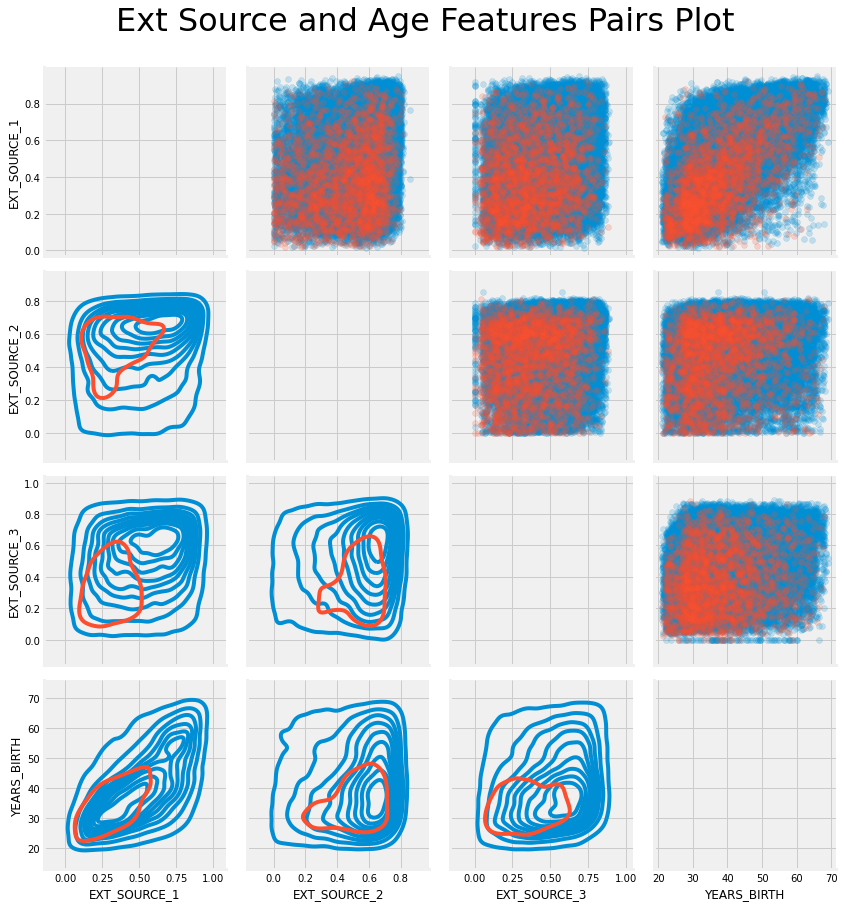

In [42]:
#copy the data for plotting
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

#Add in the age of client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

#Drop na values and limit to first 100000 rows 
plot_data = plot_data.dropna().loc[:100000, :]

#Function to calculate correlation coefficient between two values
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

#Create the pairgrid object 
grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

#upper is a scatter plot                
grid.map_upper(plt.scatter, alpha = 0.2)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', height = 32, y = 1.05);


In [56]:
#Make a new dataframe for polynomial features
poly_features = train_df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']]

poly_features_test = test_df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]

#imputer for handling missing value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

#Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

#Create the polynomial object with specified degree
poly_transformer =  PolynomialFeatures(degree = 3)


In [57]:
#train the polynomial feature 
poly_transformer.fit(poly_features)

#Transform the feature
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features Shape: ', poly_features.shape)


Polynomial Features Shape:  (307511, 35)


In [58]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'])[:15]


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [60]:
#Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names([
                                 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'
                             ])
)

#Add in the target
poly_features['TARGET'] = poly_target

#Find the correlation with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

#Display most negetive and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))


EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [62]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']
))

#Merge polynomial feature into training dataframe
poly_features['SK_ID_CURR'] = train_df['SK_ID_CURR']
train_df_poly = train_df.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polynomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test_df['SK_ID_CURR']
test_df_poly = test_df.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

#Align the dataframe
train_df_poly,test_df_poly = train_df_poly.align(test_df_poly,join='inner',axis=1)

# Print out the new shapes
print('Training data with polynomial features shape: ', train_df_poly.shape)
print('Testing data with polynomial features shape:  ', test_df_poly.shape)


Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


In [63]:
train_df_domain = train_df.copy()
test_df_domain = test_df.copy()

train_df_domain['CREDIT_INCOME_PERCENT'] = train_df_domain['AMT_CREDIT'] / train_df_domain['AMT_INCOME_TOTAL']
train_df_domain['ANNUITY_INCOME_PERCENT'] = train_df_domain['AMT_ANNUITY'] / train_df_domain['AMT_INCOME_TOTAL']
train_df_domain['CREDIT_TERM'] = train_df_domain['AMT_ANNUITY'] / train_df_domain['AMT_CREDIT']
train_df_domain['DAYS_EMPLOYED_PERCENT'] = train_df_domain['DAYS_EMPLOYED'] / train_df_domain['DAYS_BIRTH']

In [64]:
test_df_domain['CREDIT_INCOME_PERCENT'] = test_df_domain['AMT_CREDIT'] / test_df_domain['AMT_INCOME_TOTAL']
test_df_domain['ANNUITY_INCOME_PERCENT'] = test_df_domain['AMT_ANNUITY'] / test_df_domain['AMT_INCOME_TOTAL']
test_df_domain['CREDIT_TERM'] = test_df_domain['AMT_ANNUITY'] / test_df_domain['AMT_CREDIT']
test_df_domain['DAYS_EMPLOYED_PERCENT'] = test_df_domain['DAYS_EMPLOYED'] / test_df_domain['DAYS_BIRTH']

In [72]:
train_df['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [74]:
X = train_df_poly.drop(columns=['SK_ID_CURR'])
y = train_df['TARGET']
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [132]:
import re
data = train_df_poly.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_poly = test_df_poly.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [135]:
test_df_poly = test_df_poly.drop(columns=['SK_ID_CURR'])

In [115]:
X = data.drop(columns=['SK_ID_CURR'])
y = train_df['TARGET']
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [123]:
lgbcls = lgb.LGBMClassifier()
lgbcls.fit(X_train,y_train)
#scores = cross_val_score(rfc,X_train,y_train)


LGBMClassifier()

In [129]:
pred1 = lgbcls.predict(X_test)


0.03578038247995065


In [141]:
predict = lgbcls.predict(test_df_poly)
predict

array([0, 0, 0, ..., 0, 0, 0])

In [147]:
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = predict
submit.to_csv('submit1.csv',index=False)

<ipython-input-147-7c2cc20c17e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = predict
